In [1]:
'''
Author: Ivan Gvozdanovic
Date: 10/19/2023

Finding optimal tour in Traveling Salesman Problem, using tabular Q-learning algorithm.

''';

In [2]:
'''
The code works for small instances of TSP. Now check whether the policy is valid for different starting points. 
''';

In [3]:
import scipy
import scipy.io
from datetime import date, time, datetime as Date, time, datetime
from scipy import optimize
import networkx as nx
import ast
import random
import os
import re
import numpy as np
import time as Time
from operator import itemgetter
import math as m
import copy as cpy
import matplotlib.pyplot as plt
import os
import itertools
import pickle

from TabularTspEdgeSwapENV import PolytopeENV as Env


from Q_learning import Q_learning, EdgeSwap_Q_learning


from optimal_policy_extraction import edge_swap_policy_evaluation


from draw_fiber_graph import draw_graph_animation

from create_initial_solutions import create_single_TSP_initial_solution,\
                                     create_power_grid_line_initial_solution

from reward_functions import reward_cost, calculate_reward1, calculate_reward2, calculate_reward3


from helper_functions import create_tsp_polytope_graph, extract_distance_matrix, create_state_graph, create_state_edges


$\Large \textbf{Initial Solution}$

In [4]:



objective_table = [] # cost vector
initial_states = {} # dictionary holding the initial states.
reward_lists = [] # list holding the rewrds for each edge in the subproblem. We read it off to compute the travel cost.

patches = 1
nodes_per_patch = 6

#Pick the file to the problem:
file = 'TSP_MultiDiscrete_DQN'


available_actions, initial_states, distance_matrix, objective_table, reward_list = create_tsp_polytope_graph(nodes_per_patch, 
                                                                                                             patches, 
                                                                                                             initial_states, 
                                                                                                             reward_lists,
                                                                                                             file,
                                                                                                             reward_cost,
                                                                                                             1,100)


# available_actions, initial_states, distance_matrix, objective_table, reward_list, start_nodes_dict, end_nodes_dict, connecting_edges \
#                     = create_power_grid_line_initial_solution(2, nodes_per_patch, 1, 100)

print(len(initial_states[0]),initial_states[0])
print(available_actions)

[(0, 1), (0, 2), (1, 5), (2, 4), (5, 3)]

Path nodes: 
 [0, 4, 3, 2, 1, 5]
Path edges: 
 [(0, 4), (4, 3), (3, 2), (2, 1), (1, 5), (5, 0)]
sub nodes: 
 [0, 4, 3, 2, 1, 5]
sub sorted nodes: 
 [0, 1, 2, 3, 4, 5]
sub edges: 
 [(0, 4), (0, 5), (4, 3), (3, 2), (2, 1), (1, 5)]
Initial solution: 
 15 [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0]
is connected:  True
Is graph connected:  True
Edges for reward list:  [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
Sub reward list: 
 15 [37, 70, 48, 3, 6, 7, 44, 88, 65, 62, 57, 19, 5, 61, 83]
Initial reward:  148
Margin: 
 [2. 2. 2. 2. 2. 2.]
Number of actions is 9
15 [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0]
[array([ 0,  1, -1,  0,  0, -1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int8), array([ 0,  1,  0, -1,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0],
      dtype=int8), array([ 0,  1,  0,  0, -1, -1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
      dtype=int8), array([ 1,  0, -1,  0,  0, -1,  0,  0,  0,  1,  0,  0,  0,  0,  0],
      d

[(0, 1), (0, 2), (1, 5), (2, 4), (5, 3)]

In [5]:
from exact_solution import TSP_integer_program

tour_edges = TSP_integer_program(distance_matrix) # solve TSP-MZT integer program.
print("Tour edges: \n", tour_edges)

tour_edges = [(min(e),max(e)) for e in tour_edges]
or_reward = 0
for e in tour_edges:
    or_reward += objective_table[e]
print("Reward: ", or_reward)

Status: Optimal
Optimal route: 0 -> 4  1 -> 2  2 -> 5  3 -> 1  4 -> 3  5 -> 0  
Total Distance: 84.0
Tour edges: 
 [(0, 4), (1, 2), (2, 5), (3, 1), (4, 3), (5, 0)]
Reward:  84


$\Large \textbf{Main training loop}$

In [12]:
save_data = True  # save Q table data and cost vector data.
save_plots = True  # save the plots


# Model Parameters
epsilon = 1  # exploration parameter.
reward_parameter = 1
lr = 0.07  # learning rate.
discount_factor = 0.5  # discount parameter for the reward.
episode_numbers = [10000]  # number of episodes we run the algorithm on.
path_numbers = [20] # number of paths we run for each episode.
max_path_lengths = [5] # maximum number of steps allowed per a path.
table_size = len(available_actions[0]) # the size of each state and action vector.

n_step_lookup = 1 #max_path_lengths[0]#10

# Set the correct Q-learning configuration.
episode_num = episode_numbers[0]
path_num = path_numbers[0]
show_path_num = path_num*50
max_path_length = max_path_lengths[0]


combinations = list(itertools.combinations(range(nodes_per_patch), 2))
action_space_values = [list(pair) for pair in combinations]
action_space_size = nodes_per_patch-1

best_states_size = 10
best_states = {0: (initial_states[0], reward_cost(reward_list, initial_states[0]))}
print(best_states)

print(action_space_values)

{0: (array([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int32), 148)}
[[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [1, 2], [1, 3], [1, 4], [1, 5], [2, 3], [2, 4], [2, 5], [3, 4], [3, 5], [4, 5]]


In [13]:
 
# Convert dictionary values to a list of arrays
visited_states = [np.array(initial_states[0])]
visited_states = np.stack(visited_states)

#Initialize the environment.
env = Env(initial_states[0], # initial_state
         reward_list, # edge_weights
         episode_num, # total_episodes
         max_path_length,
         50, # show_path_num
         visited_states,  # visited_states
         available_actions, # basis_moves
         nodes_per_patch, # node_num
         0, # P
         best_states,
         best_states_size,
         objective_table,
         False,
         discount_factor,
         reward_function = reward_cost
         )


 Episode Number:  10000 
 Path Number:  20 
 Learning Rates:  0.07 
 Gamma:  0.5 
 Table length:  15 
 Maximum Path Length:  5
##############################  Episode:  1   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
The BEST STATES DICT is not full, add state at key  1
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
The BEST STATES DICT is not full, add state at key  2
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2),

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 5] (0, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 9 ||| Reward: -8.9375 ||| Discovered States: 25
##############################  Episode:  10   ##############################
Compute directional reward: -94 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 18 ||| Reward: -36.75 ||| Discovered States: 39
##############################  Episode:  19   ##############################
Compute directional reward: -22 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4]

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -59 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 28 ||| Reward: -33.375 ||| Discovered States: 43
##############################  Episode:  29   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5

Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 37 ||| Reward: -147.25 ||| Discovered States: 46
##############################  Episode:  38   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -10 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [3, 4] (2, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [0, 3] (0, 2) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0,

Compute directional reward: -89 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: -57 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 5] (1, 4) (4, 5)
Compute directional reward: -5 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Episode: 47 ||| Reward: -59.375 ||| Discovered States: 49
##############################  Episode:  48   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 56 ||| Reward: -31.625 ||| Discovered States: 52
##############################  Episode:  57   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -44 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 

Compute directional reward: -116 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 3) (2, 5)
Compute directional reward: -62 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: -5 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Episode: 66 ||| Reward: -73.8125 ||| Discovered States: 53
##############################  Episode:  67   ##############################
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1, 4] (0, 5) (2, 3)
Episode: 75 ||| Reward: -90.0 ||| Discovered States: 53
##############################  Episode:  76   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 5) (2, 4)
Compute directional reward: -5 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 85 ||| Reward: -15.25 ||| Discovered States: 53
##############################  Episode:  86   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Episode: 94 ||| Reward: -29.0 ||| Discovered States: 53
##############################  Episode:  95   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -32 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 4] (1, 2) (2, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -23 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Episode: 104 ||| Reward: -35.4375 ||| Discovered States: 54
##############################  Episode:  105   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 5] (0, 2) (3, 5)
Compute directional reward: -31 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 113 ||| Reward: -52.125 ||| Discovered States: 56
##############################  Episode:  114   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -49 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3,

Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 123 ||| Reward: -121.0 ||| Discovered States: 56
##############################  Episode:  124   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5]

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 132 ||| Reward: -41.625 ||| Discovered States: 57
##############################  Episode:  133   ##############################
Compute directional reward: -64 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: -31 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 4] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3,

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: -36 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 142 ||| Reward: -9.0 ||| Discovered States: 57
##############################  Episode:  143   ##############################
Compute directional reward: -32 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [2, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [2, 4]

Compute directional reward: -26 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 151 ||| Reward: -18.375 ||| Discovered States: 57
##############################  Episode:  152   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -121 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -23 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  

Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -126 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -36 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 161 ||| Reward: -60.5 ||| Discovered States: 59
##############################  Episode:  162   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: -41 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [1, 4] (0, 5) (2, 4)
Episode: 170 ||| Reward: -39.5625 ||| Discovered States: 59
##############################  Episode:  171   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 180 ||| Reward: -11.125 ||| Discovered States: 59
##############################  Episode:  181   ##############################
Compute directional reward: -32 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 4] (1, 2) (2, 3)
Compute directional reward: -32 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Episode: 189 ||| Reward: -17.25 ||| Discovered States: 59
##############################  Episode:  190   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: -95 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [

Compute directional reward: 0 for state: [1 0 0 0 1 1 0 0 0 1 0 0 1 0 1], [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)],  [1, 2] (0, 5) (1, 2)
Compute directional reward: -122 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 2] (0, 2) (1, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 2) (3, 4)
Compute directional reward: -53 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 5] (0, 4) (3, 5)
Episode: 199 ||| Reward: -97.8125 ||| Discovered States: 59
##############################  Episode:  200   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [

Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Episode: 208 ||| Reward: -25.0 ||| Discovered States: 59
##############################  Episode:  209   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -126 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [3, 

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -26 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 218 ||| Reward: -68.625 ||| Discovered States: 59
##############################  Episode:  219   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [

Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -138 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Episode: 227 ||| Reward: -104.5 ||| Discovered States: 59
##############################  Episode:  228   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Compute directional reward: -31 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 4] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [

Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: -120 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -22 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Episode: 237 ||| Reward: -31.375 ||| Discovered States: 59
##############################  Episode:  238   ##############################
Compute directional reward: -17 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  

Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Episode: 246 ||| Reward: -18.75 ||| Discovered States: 59
##############################  Episode:  247   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 1 0 0 0 0 1 0 1 1 0], [(0, 1), (0, 5), (1, 2), (2, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)], 

Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -126 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 256 ||| Reward: -132.5 ||| Discovered States: 59
##############################  Episode:  257   ##############################
Compute directional reward: -1 for state: [1 0 0 0 1 1 0 0 0 1 0 0 1 0 1], [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)],  [1, 3] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  

Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 265 ||| Reward: -50.4375 ||| Discovered States: 59
##############################  Episode:  266   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -148 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],

Compute directional reward: -67 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 275 ||| Reward: -43.625 ||| Discovered States: 60
##############################  Episode:  276   ##############################
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [4, 5] (2, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -64 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 284 ||| Reward: -93.0 ||| Discovered States: 60
##############################  Episode:  285   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -95 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0

Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 294 ||| Reward: -21.4375 ||| Discovered States: 60
##############################  Episode:  295   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Episode: 303 ||| Reward: -20.75 ||| Discovered States: 60
##############################  Episode:  304   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 313 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  314   ##############################
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 

Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Episode: 322 ||| Reward: -34.0 ||| Discovered States: 60
##############################  Episode:  323   ##############################
Compute directional reward: -64 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1,

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 4] (1, 4) (2, 3)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 332 ||| Reward: -16.6875 ||| Discovered States: 60
##############################  Episode:  333   ##############################
Compute directional reward: -41 for state: [1 0 0 0 1 1 0 0 0 0 1 0 1 1 0], [(0, 1), (0, 5), (1, 2), (2, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (2, 4)
Compute directional reward: -116 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Episode: 341 ||| Reward: -70.5 ||| Discovered States: 60
##############################  Episode:  342   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3]

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1, 3) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: -57 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1, 3) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 351 ||| Reward: -14.25 ||| Discovered States: 60
##############################  Episode:  352   ##############################
Compute directional reward: -79 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 360 ||| Reward: -18.6875 ||| Discovered States: 60
##############################  Episode:  361   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -64 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 5] (0, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -86 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 370 ||| Reward: -148.5 ||| Discovered States: 60
##############################  Episode:  371   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 

Compute directional reward: -121 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [4, 5] (2, 4) (4, 5)
Episode: 379 ||| Reward: -15.8125 ||| Discovered States: 60
##############################  Episode:  380   ##############################
Compute directional reward: -1 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -67 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Episode: 389 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  390   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 4

Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 5] (0, 4) (3, 5)
Episode: 398 ||| Reward: -82.3125 ||| Discovered States: 60
##############################  Episode:  399   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -49 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Episode: 408 ||| Reward: -35.25 ||| Discovered States: 60
##############################  Episode:  409   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Episode: 417 ||| Reward: -75.5 ||| Discovered States: 60
##############################  Episode:  418   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 3] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1

Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -17 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 4] (1, 4) (2, 3)
Episode: 427 ||| Reward: -44.3125 ||| Discovered States: 60
##############################  Episode:  428   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -41 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Episode: 436 ||| Reward: -62.75 ||| Discovered States: 60
##############################  Episode:  437   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -10 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [4, 5] (3, 4) (3, 5)
Episode: 446 ||| Reward: -60.875 ||| Discovered States: 60
##############################  Episode:  447   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 455 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  456   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 5] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: -16 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 465 ||| Reward: -2.0 ||| Discovered States: 60
##############################  Episode:  466   ##############################
Compute directional reward: -79 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: -27 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 4] (0, 3) (2, 4)
Episode: 474 ||| Reward: -31.75 ||| Discovered States: 60
##############################  Episode:  475   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3,

Compute directional reward: -17 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 484 ||| Reward: -13.0 ||| Discovered States: 60
##############################  Episode:  485   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -126 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0

Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 493 ||| Reward: -35.0625 ||| Discovered States: 60
##############################  Episode:  494   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: -26 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -53 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 503 ||| Reward: -170.9375 ||| Discovered States: 60
##############################  Episode:  504   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1, 4] (0, 5) (2, 3)
Episode: 512 ||| Reward: -27.5 ||| Discovered States: 60
##############################  Episode:  513   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: -48 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: -138 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -16 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Episode: 522 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  523   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: -20 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 4) (1, 3)
Episode: 531 ||| Reward: -11.375 ||| Discovered States: 60
##############################  Episode:  532   ##############################
Compute directional reward: -31 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 3] (0, 5) (2, 3)
Compute directional reward: -48 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Episode: 541 ||| Reward: -18.5 ||| Discovered States: 60
##############################  Episode:  542   ##############################
Compute directional reward: -16 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 550 ||| Reward: -4.5 ||| Discovered States: 60
##############################  Episode:  551   ##############################
Compute directional reward: -122 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -107 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: -72 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: -17 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 560 ||| Reward: -12.375 ||| Discovered States: 60
##############################  Episode:  561   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1,

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 569 ||| Reward: -90.0 ||| Discovered States: 60
##############################  Episode:  570   ##############################
Compute directional reward: -57 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [3, 5] (1, 4) (4, 5)
Compute directional reward: -36 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5

Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 579 ||| Reward: -42.875 ||| Discovered States: 60
##############################  Episode:  580   ##############################
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  

Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Episode: 588 ||| Reward: -18.8125 ||| Discovered States: 60
##############################  Episode:  589   ##############################
Compute directional reward: -121 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [3, 4] (2, 3) (3, 5)
Compute directional reward: -69 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: -5 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 2) (2, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)]

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: -121 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [4, 5] (2, 4) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 2] (0, 5) (1, 3)
Episode: 598 ||| Reward: -35.625 ||| Discovered States: 60
##############################  Episode:  599   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3

Compute directional reward: -127 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 3] (0, 3) (1, 4)
Episode: 607 ||| Reward: -63.75 ||| Discovered States: 60
##############################  Episode:  608   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  

Compute directional reward: -64 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Episode: 616 ||| Reward: -43.75 ||| Discovered States: 60
##############################  Episode:  617   ##############################
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -26 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -79 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [3, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 626 ||| Reward: -80.75 ||| Discovered States: 60
##############################  Episode:  627   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Episode: 635 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  636   ##############################
Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 5] (0, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 5] (0, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 645 ||| Reward: -146.25 ||| Discovered States: 60
##############################  Episode:  646   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 

Compute directional reward: -122 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 3)
Episode: 654 ||| Reward: -14.125 ||| Discovered States: 60
##############################  Episode:  655   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: -58 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -16 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 664 ||| Reward: -17.625 ||| Discovered States: 60
##############################  Episode:  665   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [

Compute directional reward: -131 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [1, 2] (0, 3) (1, 2)
Episode: 673 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  674   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  

Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Episode: 683 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  684   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [3, 4] (2, 3) (2, 4)
Episode: 692 ||| Reward: -22.25 ||| Discovered States: 60
##############################  Episode:  693   ##############################
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -31 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Episode: 702 ||| Reward: -51.0 ||| Discovered States: 60
##############################  Episode:  703   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5]

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 711 ||| Reward: -71.5 ||| Discovered States: 60
##############################  Episode:  712   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -121 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [4, 5] (2, 4) (4, 5)
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 

Compute directional reward: -15 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 721 ||| Reward: -22.4375 ||| Discovered States: 60
##############################  Episode:  722   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 730 ||| Reward: -45.625 ||| Discovered States: 60
##############################  Episode:  731   ##############################
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -138 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 740 ||| Reward: -21.0 ||| Discovered States: 60
##############################  Episode:  741   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [0

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Episode: 749 ||| Reward: -151.25 ||| Discovered States: 60
##############################  Episode:  750   ##############################
Compute directional reward: -40 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -36 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [

Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Episode: 759 ||| Reward: -60.5 ||| Discovered States: 60
##############################  Episode:  760   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 5] (1, 4) (2, 5)
Episode: 768 ||| Reward: -36.375 ||| Discovered States: 60
##############################  Episode:  769   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -36 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -53 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 778 ||| Reward: -0.125 ||| Discovered States: 60
##############################  Episode:  779   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] 

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 2) (2, 5)
Episode: 787 ||| Reward: -30.25 ||| Discovered States: 60
##############################  Episode:  788   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2]

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 797 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  798   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 3]

Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: -45 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Episode: 806 ||| Reward: -42.3125 ||| Discovered States: 60
##############################  Episode:  807   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: -1 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: -5 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: -32 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 5] (1, 4) (3, 5)
Episode: 816 ||| Reward: -3.125 ||| Discovered States: 60
##############################  Episode:  817   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1

Compute directional reward: -64 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Episode: 825 ||| Reward: -64.6875 ||| Discovered States: 60
##############################  Episode:  826   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Episode: 835 ||| Reward: -101.375 ||| Discovered States: 60
##############################  Episode:  836   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1,

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Episode: 844 ||| Reward: -55.75 ||| Discovered States: 60
##############################  Episode:  845   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 854 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  855   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 0 1 0 1 0 1 1 0 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Episode: 863 ||| Reward: -14.125 ||| Discovered States: 60
##############################  Episode:  864   ##############################
Compute directional reward: -116 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -36 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Episode: 873 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  874   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3]

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Episode: 882 ||| Reward: -59.25 ||| Discovered States: 60
##############################  Episode:  883   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -31 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)], 

Compute directional reward: -53 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 4] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 892 ||| Reward: -45.125 ||| Discovered States: 60
##############################  Episode:  893   ##############################
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: -81 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Episode: 901 ||| Reward: -69.75 ||| Discovered States: 60
##############################  Episode:  902   ##############################
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Episode: 911 ||| Reward: -2.5 ||| Discovered States: 60
##############################  Episode:  912   ##############################
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4]

Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 920 ||| Reward: -17.0625 ||| Discovered States: 60
##############################  Episode:  921   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 1 0 0 0 1 0 0 1 0 1], [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)],  [1, 2] (0, 5) (1, 2)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: -49 for state: [1 0 0 0 1 0 0 1 0 1 0 1 1 0 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 5), (3, 4)],  [2, 3] (1, 4) (2, 3)
Compute directional reward: -94 for state: [1 0 0 0 1 0 0 1 0 1 1 0 0 1 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 5] (1, 4) (2, 5)
Episode: 930 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  931   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4]

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 3] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 939 ||| Reward: -72.0 ||| Discovered States: 60
##############################  Episode:  940   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2]

Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -81 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -63 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Episode: 949 ||| Reward: -28.125 ||| Discovered States: 60
##############################  Episode:  950   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 4] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0,

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 958 ||| Reward: -104.125 ||| Discovered States: 60
##############################  Episode:  959   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -16 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 968 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  969   ##############################
Compute directional reward: -57 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1, 3) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0

Compute directional reward: -5 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 4] (0, 3) (2, 5)
Episode: 977 ||| Reward: -22.5625 ||| Discovered States: 60
##############################  Episode:  978   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 987 ||| Reward: -10.625 ||| Discovered States: 60
##############################  Episode:  988   ##############################
Compute directional reward: -5 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [0, 4] (0, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 4) (1, 3)
Episode: 996 ||| Reward: -40.0 ||| Discovered States: 60
##############################  Episode:  997   ##############################
Compute directional reward: -5 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 2) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -26 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5]

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -106 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [3, 5] (1, 4) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1006 ||| Reward: -27.5 ||| Discovered States: 60
##############################  Episode:  1007   ##############################
Compute directional reward: -63 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [1

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 3] (1, 5) (2, 3)
Episode: 1015 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  1016   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -31 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Episode: 1025 ||| Reward: -35.375 ||| Discovered States: 60
##############################  Episode:  1026   ##############################
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 3] (0, 4) (1, 5)
Episode: 1034 ||| Reward: -15.8125 ||| Discovered States: 60
##############################  Episode:  1035   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: -40 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: -15 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [2, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Episode: 1044 ||| Reward: -48.25 ||| Discovered States: 60
##############################  Episode:  1045   ##############################
Compute directional reward: -80 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  

Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1053 ||| Reward: -37.25 ||| Discovered States: 60
##############################  Episode:  1054   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0,

Episode: 1062 ||| Reward: -70.125 ||| Discovered States: 60
##############################  Episode:  1063   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 1063 ||| Reward: -40.9375 ||| Discovered States: 60
##############################  Episode:  1064   ###############

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Episode: 1072 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1073   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: -15 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [3, 

Episode: 1081 ||| Reward: -69.375 ||| Discovered States: 60
##############################  Episode:  1082   ##############################
Compute directional reward: -137 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [2, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 5) (2, 4)
Compute directional reward: -5 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Episode: 1082 ||| Reward: -141.0625 ||| Discovered States: 60
##############################  Episode:  1083   #############

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 1091 ||| Reward: -1.5625 ||| Discovered States: 60
##############################  Episode:  1092   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)], 

Episode: 1100 ||| Reward: -22.5 ||| Discovered States: 60
##############################  Episode:  1101   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 1101 ||| Reward: -8.625 ||| Discovered States: 60
##############################  Episode:  1102   #####################

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 1110 ||| Reward: -22.25 ||| Discovered States: 60
##############################  Episode:  1111   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [

Episode: 1119 ||| Reward: -17.3125 ||| Discovered States: 60
##############################  Episode:  1120   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -36 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 1120 ||| Reward: -26.625 ||| Discovered States: 60
##############################  Episode:  1121   ###############

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 1129 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  1130   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 1138 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1139   ##############################
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -86 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 1148 ||| Reward: -25.0 ||| Discovered States: 60
##############################  Episode:  1149   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0

Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Episode: 1157 ||| Reward: -10.6875 ||| Discovered States: 60
##############################  Episode:  1158   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 3] (0, 5) (2, 3)
Compute directional reward: -48 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)], 

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: -48 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [1, 5] (0, 2) (3, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Episode: 1167 ||| Reward: -80.0 ||| Discovered States: 60
##############################  Episode:  1168   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: -41 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Episode: 1176 ||| Reward: -37.0 ||| Discovered States: 60
##############################  Episode:  1177   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3,

Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -89 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [1, 3] (0, 3) (1, 4)
Episode: 1186 ||| Reward: -25.5625 ||| Discovered States: 60
##############################  Episode:  1187   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],

Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 1195 ||| Reward: -9.75 ||| Discovered States: 60
##############################  Episode:  1196   ##############################
Compute directional reward: -22 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [

Compute directional reward: -69 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 2) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 1205 ||| Reward: -69.0 ||| Discovered States: 60
##############################  Episode:  1206   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Episode: 1214 ||| Reward: -23.75 ||| Discovered States: 60
##############################  Episode:  1215   ##############################
Compute directional reward: -15 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)], 

Episode: 1223 ||| Reward: -74.75 ||| Discovered States: 60
##############################  Episode:  1224   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 1224 ||| Reward: -3.75 ||| Discovered States: 60
##############################  Episode:  1225   ######################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1233 ||| Reward: -15.5 ||| Discovered States: 60
##############################  Episode:  1234   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Episode: 1242 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1243   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -94 for state: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1], [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)],  [3, 4] (2, 4) (3, 5)
Compute directional reward: -49 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [2, 3] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 3] (0, 2) (1, 4)
Episode: 1243 ||| Reward: -29.625 ||| Discovered States: 60
##############################  Episode:  1244   #####################

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [2, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Episode: 1252 ||| Reward: -155.875 ||| Discovered States: 60
##############################  Episode:  1253   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Episode: 1261 ||| Reward: -49.0 ||| Discovered States: 60
##############################  Episode:  1262   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 1262 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1263   ###########################

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1271 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1272   ##############################
Compute directional reward: -89 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [2, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] 

Episode: 1280 ||| Reward: -40.0625 ||| Discovered States: 60
##############################  Episode:  1281   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -116 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 1281 ||| Reward: -67.8125 ||| Discovered States: 60
##############################  Episode:  1282   #############

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 1290 ||| Reward: -22.5 ||| Discovered States: 60
##############################  Episode:  1291   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [

Episode: 1299 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  1300   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -122 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 3] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1300 ||| Reward: -61.0 ||| Discovered States: 60
##############################  Episode:  1301   ####################

Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 1309 ||| Reward: -198.25 ||| Discovered States: 60
##############################  Episode:  1310   ##############################
Compute directional reward: -89 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [4, 5] (3, 4) (3, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Episode: 1318 ||| Reward: -18.5 ||| Discovered States: 60
##############################  Episode:  1319   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 1328 ||| Reward: -22.875 ||| Discovered States: 60
##############################  Episode:  1329   ##############################
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 4) (1, 3)
Episode: 1337 ||| Reward: -68.125 ||| Discovered States: 60
##############################  Episode:  1338   ##############################
Compute directional reward: -138 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  

Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -53 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 1347 ||| Reward: -89.5 ||| Discovered States: 60
##############################  Episode:  1348   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1,

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 1356 ||| Reward: -33.375 ||| Discovered States: 60
##############################  Episode:  1357   ##############################
Compute directional reward: -138 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -4 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 1366 ||| Reward: -19.5 ||| Discovered States: 60
##############################  Episode:  1367   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 1375 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  1376   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 2] (0, 2) (1, 4)
Compute directional reward: -121 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [3, 4] (2, 3) (3, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 5] (0, 2) (4, 5)
Episode: 1385 ||| Reward: -52.125 ||| Discovered States: 60
##############################  Episode:  1386   ##############################
Compute directional reward: -1 for state: [1 0 0 0 1 0 0 1 0 1 1 0 0 1 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 4), (3, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Episode: 1394 ||| Reward: -12.875 ||| Discovered States: 60
##############################  Episode:  1395   ##############################
Compute directional reward: -5 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 2) (2, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -94 for state: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1], [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)],  [3, 4] (2, 4) (3, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Episode: 1404 ||| Reward: -50.6875 ||| Discovered States: 60
##############################  Episode:  1405   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 1413 ||| Reward: -2.375 ||| Discovered States: 60
##############################  Episode:  1414   ##############################
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -44 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)], 

Compute directional reward: -69 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 1423 ||| Reward: -155.5 ||| Discovered States: 60
##############################  Episode:  1424   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Episode: 1432 ||| Reward: -18.5 ||| Discovered States: 60
##############################  Episode:  1433   ##############################
Compute directional reward: -16 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1442 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  1443   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1451 ||| Reward: -122.0 ||| Discovered States: 60
##############################  Episode:  1452   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 1461 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  1462   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: -26 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1470 ||| Reward: -69.0 ||| Discovered States: 60
##############################  Episode:  1471   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -106 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [3, 5] (1, 4) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4

Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: -5 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Episode: 1480 ||| Reward: -75.25 ||| Discovered States: 60
##############################  Episode:  1481   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 1489 ||| Reward: -32.75 ||| Discovered States: 60
##############################  Episode:  1490   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -31 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1499 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1500   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 1508 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1509   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4]

Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 1518 ||| Reward: -24.5 ||| Discovered States: 60
##############################  Episode:  1519   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4

Compute directional reward: -116 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 1527 ||| Reward: -14.5 ||| Discovered States: 60
##############################  Episode:  1528   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: -79 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [3, 5] (1, 4) (3, 5)
Episode: 1537 ||| Reward: -105.9375 ||| Discovered States: 60
##############################  Episode:  1538   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 3] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 1546 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1547   ##############################
Compute directional reward: -53 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 4] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: -57 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1, 3) (3, 5)
Compute directional reward: -89 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [1,

Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 1556 ||| Reward: -9.25 ||| Discovered States: 60
##############################  Episode:  1557   ##############################
Compute directional reward: -16 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1

Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Episode: 1565 ||| Reward: -18.25 ||| Discovered States: 60
##############################  Episode:  1566   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 1575 ||| Reward: -34.5 ||| Discovered States: 60
##############################  Episode:  1576   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 1584 ||| Reward: -29.5 ||| Discovered States: 60
##############################  Episode:  1585   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 1594 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  1595   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 1], [(0, 2), (0, 3), (1, 2), (1, 5), (3, 4), (4, 5)],  [0, 3] (0, 2) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 

Compute directional reward: -32 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Episode: 1603 ||| Reward: -15.625 ||| Discovered States: 60
##############################  Episode:  1604   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -5 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -16 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1613 ||| Reward: -2.0 ||| Discovered States: 60
##############################  Episode:  1614   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -116 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [2,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1622 ||| Reward: -15.5 ||| Discovered States: 60
##############################  Episode:  1623   ##############################
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1,

Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -122 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: -22 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Episode: 1632 ||| Reward: -101.25 ||| Discovered States: 60
##############################  Episode:  1633   ##############################
Compute directional reward: -57 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 5] (1, 4) (4, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],

Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 1641 ||| Reward: -44.6875 ||| Discovered States: 60
##############################  Episode:  1642   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1651 ||| Reward: -16.0 ||| Discovered States: 60
##############################  Episode:  1652   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1660 ||| Reward: -37.25 ||| Discovered States: 60
##############################  Episode:  1661   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 1670 ||| Reward: -48.0 ||| Discovered States: 60
##############################  Episode:  1671   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Episode: 1679 ||| Reward: -27.0 ||| Discovered States: 60
##############################  Episode:  1680   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [4, 5] (3, 4) (3, 5)
Episode: 1689 ||| Reward: -42.0 ||| Discovered States: 60
##############################  Episode:  1690   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0

Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 1698 ||| Reward: -27.875 ||| Discovered States: 60
##############################  Episode:  1699   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 1708 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  1709   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1,

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 1717 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  1718   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0,

Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 1727 ||| Reward: -4.5 ||| Discovered States: 60
##############################  Episode:  1728   ##############################
Compute directional reward: -89 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: -1 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: -26 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 1736 ||| Reward: -84.875 ||| Discovered States: 60
##############################  Episode:  1737   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1746 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1747   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 1755 ||| Reward: -12.875 ||| Discovered States: 60
##############################  Episode:  1756   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)], 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1765 ||| Reward: -51.75 ||| Discovered States: 60
##############################  Episode:  1766   ##############################
Compute directional reward: -15 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1774 ||| Reward: -19.75 ||| Discovered States: 60
##############################  Episode:  1775   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: -59 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 1784 ||| Reward: -95.3125 ||| Discovered States: 60
##############################  Episode:  1785   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1793 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1794   ##############################
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4]

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 1803 ||| Reward: -61.1875 ||| Discovered States: 60
##############################  Episode:  1804   ##############################
Compute directional reward: -48 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [1, 5] (0, 2) (3, 5)
Compute directional reward: -106 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Episode: 1812 ||| Reward: -41.9375 ||| Discovered States: 60
##############################  Episode:  1813   ##############################
Compute directional reward: -41 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -58 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3,

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Episode: 1822 ||| Reward: -13.875 ||| Discovered States: 60
##############################  Episode:  1823   ##############################
Compute directional reward: -58 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1831 ||| Reward: -20.75 ||| Discovered States: 60
##############################  Episode:  1832   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -31 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1, 3) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1841 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1842   ##############################
Compute directional reward: -68 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] 

Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Episode: 1850 ||| Reward: -33.25 ||| Discovered States: 60
##############################  Episode:  1851   ##############################
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [

Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 1860 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  1861   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [4, 5] (3, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 1869 ||| Reward: -79.1875 ||| Discovered States: 60
##############################  Episode:  1870   ##############################
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: -53 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],

Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 1879 ||| Reward: -32.0 ||| Discovered States: 60
##############################  Episode:  1880   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Episode: 1888 ||| Reward: -111.375 ||| Discovered States: 60
##############################  Episode:  1889   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 1898 ||| Reward: -12.6875 ||| Discovered States: 60
##############################  Episode:  1899   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 1907 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  1908   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3,

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 1], [(0, 2), (0, 3), (1, 2), (1, 5), (3, 4), (4, 5)],  [0, 3] (0, 2) (1, 5)
Episode: 1917 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1918   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1926 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  1927   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: -48 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: -138 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 5] (1, 4) (2, 5)
Compute directional reward: -64 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Episode: 1936 ||| Reward: -42.0 ||| Discovered States: 60
##############################  Episode:  1937   ##############################
Compute directional reward: -1 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: -57 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [3

Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 1945 ||| Reward: -61.5625 ||| Discovered States: 60
##############################  Episode:  1946   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)], 

Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -17 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1955 ||| Reward: -60.125 ||| Discovered States: 60
##############################  Episode:  1956   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 1964 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1965   ##############################
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [

Compute directional reward: -59 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Episode: 1974 ||| Reward: -32.5 ||| Discovered States: 60
##############################  Episode:  1975   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 1983 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  1984   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 1993 ||| Reward: -19.75 ||| Discovered States: 60
##############################  Episode:  1994   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 2002 ||| Reward: -43.625 ||| Discovered States: 60
##############################  Episode:  2003   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 3] (0, 3) (2, 5)
Compute directional reward: -32 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: -121 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [4, 5] (2, 4) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 2012 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  2013   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2021 ||| Reward: -59.0 ||| Discovered States: 60
##############################  Episode:  2022   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -15 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -86 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3,

Compute directional reward: -79 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [2, 4] (1, 4) (3, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 2) (3, 4)
Episode: 2031 ||| Reward: -39.5 ||| Discovered States: 60
##############################  Episode:  2032   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 2040 ||| Reward: -131.25 ||| Discovered States: 60
##############################  Episode:  2041   ##############################
Compute directional reward: -15 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)]

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2050 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2051   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [3, 4] (1

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Episode: 2059 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  2060   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 2069 ||| Reward: -8.625 ||| Discovered States: 60
##############################  Episode:  2070   ##############################
Compute directional reward: -17 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 2] (0, 4) (1, 2)
Episode: 2078 ||| Reward: -34.0 ||| Discovered States: 60
##############################  Episode:  2079   ##############################
Compute directional reward: -5 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [0, 4] (0, 2) (2, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5]

##############################  Episode:  2088   ##############################
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 3] (0, 3) (1, 4)
Episode: 2088 ||| Reward: -151.875 ||| Discovered States: 60
##############################  Episode:  2089   ##############################
Compute directional reward: -31 for state:

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: -131 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [1, 2] (0, 3) (1, 2)
Episode: 2097 ||| Reward: -59.3125 ||| Discovered States: 60
##############################  Episode:  2098   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)]

Episode: 2106 ||| Reward: -20.0 ||| Discovered States: 60
##############################  Episode:  2107   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2107 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  2108   ########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2116 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  2117   ##############################
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [1, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1,

Episode: 2125 ||| Reward: -44.875 ||| Discovered States: 60
##############################  Episode:  2126   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Episode: 2126 ||| Reward: -29.625 ||| Discovered States: 60
##############################  Episode:  2127   #################

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 3] (1, 5) (2, 3)
Episode: 2135 ||| Reward: -30.0 ||| Discovered States: 60
##############################  Episode:  2136   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0,

Episode: 2144 ||| Reward: -14.875 ||| Discovered States: 60
##############################  Episode:  2145   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Episode: 2145 ||| Reward: -9.25 ||| Discovered States: 60
##############################  Episode:  2146   ####################

Compute directional reward: -64 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Episode: 2154 ||| Reward: -23.375 ||| Discovered States: 60
##############################  Episode:  2155   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [

Episode: 2163 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  2164   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 2164 ||| Reward: -80.375 ||| Discovered States: 60
##############################  Episode:  2165   ##################

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Episode: 2173 ||| Reward: -37.0 ||| Discovered States: 60
##############################  Episode:  2174   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: -53 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0

Episode: 2182 ||| Reward: -71.625 ||| Discovered States: 60
##############################  Episode:  2183   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2183 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  2184   ######################

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 2192 ||| Reward: -3.9375 ||| Discovered States: 60
##############################  Episode:  2193   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  

Episode: 2201 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  2202   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 2202 ||| Reward: -78.5 ||| Discovered States: 60
##############################  Episode:  2203   ####################

Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 0 1 0 1 0 1 1 0 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Episode: 2211 ||| Reward: -22.25 ||| Discovered States: 60
##############################  Episode:  2212   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: -59 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0

Episode: 2220 ||| Reward: -22.125 ||| Discovered States: 60
##############################  Episode:  2221   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 2221 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  2222   ####################

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Episode: 2230 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  2231   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] 

Compute directional reward: -53 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 4] (0, 4) (3, 5)
Episode: 2239 ||| Reward: -19.6875 ||| Discovered States: 60
##############################  Episode:  2240   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)], 

Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 2249 ||| Reward: -68.5 ||| Discovered States: 60
##############################  Episode:  2250   ##############################
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2258 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2259   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 3] (0, 2) (1, 3)
Episode: 2268 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2269   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 2277 ||| Reward: -39.75 ||| Discovered States: 60
##############################  Episode:  2278   ##############################
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [4, 5] (2, 3) (4, 5)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 2287 ||| Reward: -59.75 ||| Discovered States: 60
##############################  Episode:  2288   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 2296 ||| Reward: -14.75 ||| Discovered States: 60
##############################  Episode:  2297   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 2306 ||| Reward: -37.25 ||| Discovered States: 60
##############################  Episode:  2307   ##############################
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 2315 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  2316   ##############################
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2325 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2326   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0

Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 2334 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  2335   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 2344 ||| Reward: -61.625 ||| Discovered States: 60
##############################  Episode:  2345   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 4] (2, 5) (3, 4)
Compute directional reward: -94 for state: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1], [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)],  

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 2353 ||| Reward: -29.0625 ||| Discovered States: 60
##############################  Episode:  2354   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)], 

Compute directional reward: 0 for state: [1 0 0 0 1 1 0 0 0 1 0 0 1 0 1], [(0, 1), (0, 5), (1, 2), (2, 3), (3, 4), (4, 5)],  [1, 2] (0, 5) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 2363 ||| Reward: -20.25 ||| Discovered States: 60
##############################  Episode:  2364   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2372 ||| Reward: -3.875 ||| Discovered States: 60
##############################  Episode:  2373   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: -17 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 1], [(0, 2), (0, 3), (1, 2), (1, 5), (3, 4), (4, 5)],  [0, 3] (0, 2) (1, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 2382 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2383   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 2391 ||| Reward: -21.75 ||| Discovered States: 60
##############################  Episode:  2392   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -138 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [2, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],

Episode: 2400 ||| Reward: -41.3125 ||| Discovered States: 60
##############################  Episode:  2401   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 2401 ||| Reward: -3.75 ||| Discovered States: 60
##############################  Episode:  2402   ####################

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Episode: 2410 ||| Reward: -2.5 ||| Discovered States: 60
##############################  Episode:  2411   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2,

Episode: 2419 ||| Reward: -75.6875 ||| Discovered States: 60
##############################  Episode:  2420   ##############################
Compute directional reward: -26 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2420 ||| Reward: -55.5 ||| Discovered States: 60
##############################  Episode:  2421   ##################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2429 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2430   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Episode: 2438 ||| Reward: -3.9375 ||| Discovered States: 60
##############################  Episode:  2439   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 2439 ||| Reward: -29.5 ||| Discovered States: 60
##############################  Episode:  2440   #####################

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2448 ||| Reward: -122.0 ||| Discovered States: 60
##############################  Episode:  2449   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: -5 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2

Episode: 2457 ||| Reward: -39.9375 ||| Discovered States: 60
##############################  Episode:  2458   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Episode: 2458 ||| Reward: -21.125 ||| Discovered States: 60
##############################  Episode:  2459   ###############

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Episode: 2467 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  2468   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: -1 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)], 

Episode: 2476 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  2477   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2477 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  2478   ####################

Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2486 ||| Reward: -56.75 ||| Discovered States: 60
##############################  Episode:  2487   ##############################
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [

Episode: 2495 ||| Reward: -18.1875 ||| Discovered States: 60
##############################  Episode:  2496   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 2496 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  2497   #################

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2505 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  2506   ##############################
Compute directional reward: -26 for state: [1 0 0 0 1 0 0 1 0 1 0 1 1 0 0], [(0, 1), (0, 5), (1, 4), (2, 3), (2, 5), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Episode: 2514 ||| Reward: -37.25 ||| Discovered States: 60
##############################  Episode:  2515   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Episode: 2524 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  2525   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 2533 ||| Reward: -4.5 ||| Discovered States: 60
##############################  Episode:  2534   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2543 ||| Reward: -32.0 ||| Discovered States: 60
##############################  Episode:  2544   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 2

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 2552 ||| Reward: -22.25 ||| Discovered States: 60
##############################  Episode:  2553   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [

Episode: 2561 ||| Reward: -9.0 ||| Discovered States: 60
##############################  Episode:  2562   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: -68 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: -121 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [4, 5] (2, 4) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2562 ||| Reward: -49.125 ||| Discovered States: 60
##############################  Episode:  2563   ###################

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Episode: 2571 ||| Reward: -38.1875 ||| Discovered States: 60
##############################  Episode:  2572   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)], 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Episode: 2580 ||| Reward: -13.0 ||| Discovered States: 60
##############################  Episode:  2581   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -31 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Episode: 2590 ||| Reward: -18.8125 ||| Discovered States: 60
##############################  Episode:  2591   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Episode: 2599 ||| Reward: -46.5625 ||| Discovered States: 60
##############################  Episode:  2600   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)], 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2609 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2610   ##############################
Compute directional reward: -48 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [1, 5] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [0, 3] 

Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0, 3) (1, 2)
Episode: 2618 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2619   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 2628 ||| Reward: -19.5 ||| Discovered States: 60
##############################  Episode:  2629   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0,

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2637 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  2638   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Episode: 2647 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2648   ##############################
Compute directional reward: -72 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 3] 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 2656 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2657   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] 

Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Episode: 2666 ||| Reward: -60.5 ||| Discovered States: 60
##############################  Episode:  2667   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2675 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2676   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 2685 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2686   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 2694 ||| Reward: -9.8125 ||| Discovered States: 60
##############################  Episode:  2695   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)], 

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 2704 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  2705   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0,

Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 2713 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  2714   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2723 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2724   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2732 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2733   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 2742 ||| Reward: -67.1875 ||| Discovered States: 60
##############################  Episode:  2743   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2751 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2752   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] 

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 2761 ||| Reward: -2.25 ||| Discovered States: 60
##############################  Episode:  2762   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 2770 ||| Reward: -38.4375 ||| Discovered States: 60
##############################  Episode:  2771   ##############################
Compute directional reward: -20 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 3] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Episode: 2780 ||| Reward: -3.0625 ||| Discovered States: 60
##############################  Episode:  2781   ##############################
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2789 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  2790   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -121 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [3, 4] (2, 3) (3, 5)
Compute directional reward: -32 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [2, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0,

Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [1, 4] (0, 5) (3, 4)
Episode: 2799 ||| Reward: -20.0 ||| Discovered States: 60
##############################  Episode:  2800   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Episode: 2808 ||| Reward: -11.75 ||| Discovered States: 60
##############################  Episode:  2809   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [3, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 2818 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2819   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Episode: 2827 ||| Reward: -2.5 ||| Discovered States: 60
##############################  Episode:  2828   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2837 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2838   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] 

Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 2846 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  2847   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 2856 ||| Reward: -5.5625 ||| Discovered States: 60
##############################  Episode:  2857   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 2865 ||| Reward: -23.5 ||| Discovered States: 60
##############################  Episode:  2866   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 2875 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  2876   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 2884 ||| Reward: -60.625 ||| Discovered States: 60
##############################  Episode:  2885   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  

Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2894 ||| Reward: -74.5 ||| Discovered States: 60
##############################  Episode:  2895   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2903 ||| Reward: -23.5 ||| Discovered States: 60
##############################  Episode:  2904   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 2] (0, 2) (1, 4)
Episode: 2913 ||| Reward: -9.25 ||| Discovered States: 60
##############################  Episode:  2914   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [2, 

Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 2922 ||| Reward: -19.6875 ||| Discovered States: 60
##############################  Episode:  2923   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -107 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 2932 ||| Reward: -1.0 ||| Discovered States: 60
##############################  Episode:  2933   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Episode: 2941 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  2942   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 3] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2951 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2952   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 2960 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  2961   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2970 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2971   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 2979 ||| Reward: -121.5625 ||| Discovered States: 60
##############################  Episode:  2980   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 2989 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  2990   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 2998 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  2999   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [1, 4] (0, 5) (3, 4)
Compute directional reward: -63 for state: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 1], [(0, 2), (0, 3), (1, 2), (1, 5), (3, 4), (4, 5)],  [1, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [1, 3] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3008 ||| Reward: -12.0 ||| Discovered States: 60
##############################  Episode:  3009   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Episode: 3017 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3018   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 3027 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  3028   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3036 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3037   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3046 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3047   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3055 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3056   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] 

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3065 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3066   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -44 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] 

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 3074 ||| Reward: -70.25 ||| Discovered States: 60
##############################  Episode:  3075   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Episode: 3084 ||| Reward: -29.625 ||| Discovered States: 60
##############################  Episode:  3085   ##############################
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 3093 ||| Reward: -42.0 ||| Discovered States: 60
##############################  Episode:  3094   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: -68 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 1 1 0 0 0 1], [(0, 1), (0, 3), (1, 5), (2, 3), (2, 4), (4, 5)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0,

Compute directional reward: -86 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 3103 ||| Reward: -43.0 ||| Discovered States: 60
##############################  Episode:  3104   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 3112 ||| Reward: -91.5625 ||| Discovered States: 60
##############################  Episode:  3113   ##############################
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)

Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 3122 ||| Reward: -52.0 ||| Discovered States: 60
##############################  Episode:  3123   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 3131 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3132   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Episode: 3141 ||| Reward: -34.5 ||| Discovered States: 60
##############################  Episode:  3142   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3150 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3151   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3160 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3161   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 3169 ||| Reward: -48.5 ||| Discovered States: 60
##############################  Episode:  3170   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 3] (0, 4) (1, 5)
Episode: 3179 ||| Reward: -4.0625 ||| Discovered States: 60
##############################  Episode:  3180   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 3188 ||| Reward: -21.75 ||| Discovered States: 60
##############################  Episode:  3189   ##############################
Compute directional reward: -58 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Episode: 3198 ||| Reward: -17.375 ||| Discovered States: 60
##############################  Episode:  3199   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)], 

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 3207 ||| Reward: -32.75 ||| Discovered States: 60
##############################  Episode:  3208   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Episode: 3217 ||| Reward: -45.6875 ||| Discovered States: 60
##############################  Episode:  3218   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  

Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 3226 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  3227   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)], 

Compute directional reward: -10 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3236 ||| Reward: -13.0 ||| Discovered States: 60
##############################  Episode:  3237   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [1, 2] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0,

Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 3245 ||| Reward: -28.625 ||| Discovered States: 60
##############################  Episode:  3246   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3255 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3256   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Episode: 3264 ||| Reward: -35.6875 ||| Discovered States: 60
##############################  Episode:  3265   ##############################
Compute directional reward: -127 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 3274 ||| Reward: -4.5 ||| Discovered States: 60
##############################  Episode:  3275   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 1 0 0 0 0 1 0 1 1 0], [(0, 1), (0, 5), (1, 2), (2, 4), (3, 4), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3283 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3284   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 3293 ||| Reward: -81.125 ||| Discovered States: 60
##############################  Episode:  3294   ##############################
Compute directional reward: -48 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 3302 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  3303   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Episode: 3312 ||| Reward: -18.5 ||| Discovered States: 60
##############################  Episode:  3313   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [0

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 3321 ||| Reward: -15.625 ||| Discovered States: 60
##############################  Episode:  3322   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Episode: 3331 ||| Reward: -18.9375 ||| Discovered States: 60
##############################  Episode:  3332   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 3340 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  3341   ##############################
Compute directional reward: -40 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  

Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3350 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3351   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3359 ||| Reward: -0.25 ||| Discovered States: 60
##############################  Episode:  3360   ##############################
Compute directional reward: -32 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [2, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 3369 ||| Reward: -37.25 ||| Discovered States: 60
##############################  Episode:  3370   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 3378 ||| Reward: -11.125 ||| Discovered States: 60
##############################  Episode:  3379   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 3388 ||| Reward: -49.0 ||| Discovered States: 60
##############################  Episode:  3389   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3397 ||| Reward: -6.5 ||| Discovered States: 60
##############################  Episode:  3398   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: -95 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Episode: 3407 ||| Reward: -45.625 ||| Discovered States: 60
##############################  Episode:  3408   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)]

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 3416 ||| Reward: -54.625 ||| Discovered States: 60
##############################  Episode:  3417   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 3426 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  3427   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 

Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Episode: 3435 ||| Reward: -2.5 ||| Discovered States: 60
##############################  Episode:  3436   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3445 ||| Reward: -86.0 ||| Discovered States: 60
##############################  Episode:  3446   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 3454 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3455   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: -48 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -53 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 5] (0, 4) (3, 5)
Episode: 3464 ||| Reward: -27.3125 ||| Discovered States: 60
##############################  Episode:  3465   ##############################
Compute directional reward: -122 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 2] (0, 2) (1, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3473 ||| Reward: -30.5 ||| Discovered States: 60
##############################  Episode:  3474   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 3483 ||| Reward: -38.75 ||| Discovered States: 60
##############################  Episode:  3484   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 3492 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  3493   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3502 ||| Reward: -1.0 ||| Discovered States: 60
##############################  Episode:  3503   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3511 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3512   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 3521 ||| Reward: -8.625 ||| Discovered States: 60
##############################  Episode:  3522   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Episode: 3530 ||| Reward: -5.0 ||| Discovered States: 60
##############################  Episode:  3531   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 3540 ||| Reward: -25.25 ||| Discovered States: 60
##############################  Episode:  3541   ##############################
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Episode: 3549 ||| Reward: -7.5625 ||| Discovered States: 60
##############################  Episode:  3550   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 3559 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3560   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3568 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3569   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 3] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 5] 

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 3578 ||| Reward: -74.75 ||| Discovered States: 60
##############################  Episode:  3579   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 3587 ||| Reward: -14.75 ||| Discovered States: 60
##############################  Episode:  3588   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [3, 4] (1, 4) (2, 5)
Episode: 3597 ||| Reward: -5.0 ||| Discovered States: 60
##############################  Episode:  3598   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: -79 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3606 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3607   ##############################
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Episode: 3616 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  3617   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3625 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  3626   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3635 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3636   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: -64 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [2, 4] 

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Episode: 3644 ||| Reward: -13.9375 ||| Discovered States: 60
##############################  Episode:  3645   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3654 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3655   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 3663 ||| Reward: -11.5 ||| Discovered States: 60
##############################  Episode:  3664   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Episode: 3673 ||| Reward: -35.4375 ||| Discovered States: 60
##############################  Episode:  3674   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3682 ||| Reward: -20.5 ||| Discovered States: 60
##############################  Episode:  3683   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3692 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3693   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 3701 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  3702   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 4] (1, 3) (2, 4)
Episode: 3711 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  3712   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 

Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 3720 ||| Reward: -9.25 ||| Discovered States: 60
##############################  Episode:  3721   ##############################
Compute directional reward: -68 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 3730 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3731   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 3739 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3740   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2]

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Episode: 3749 ||| Reward: -57.25 ||| Discovered States: 60
##############################  Episode:  3750   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3,

Compute directional reward: -94 for state: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1], [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)],  [3, 4] (2, 4) (3, 5)
Episode: 3758 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  3759   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -148 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Episode: 3768 ||| Reward: -8.9375 ||| Discovered States: 60
##############################  Episode:  3769   ##############################
Compute directional reward: -64 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [2, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 3777 ||| Reward: -6.125 ||| Discovered States: 60
##############################  Episode:  3778   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: -10 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] (0, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3787 ||| Reward: -5.0 ||| Discovered States: 60
##############################  Episode:  3788   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 3796 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3797   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 5] 

Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 3806 ||| Reward: -69.5 ||| Discovered States: 60
##############################  Episode:  3807   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3815 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3816   ##############################
Compute directional reward: -79 for state: [1 1 0 0 0 0 0 1 0 1 0 0 0 1 1], [(0, 1), (0, 2), (1, 4), (2, 3), (3, 5), (4, 5)],  [2, 4] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 2) (2, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -62 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5] (1, 2) (4, 5)
Compute directional reward: -95 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Episode: 3825 ||| Reward: -42.125 ||| Discovered States: 60
##############################  Episode:  3826   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Episode: 3834 ||| Reward: -29.125 ||| Discovered States: 60
##############################  Episode:  3835   ##############################
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)], 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3844 ||| Reward: -59.0 ||| Discovered States: 60
##############################  Episode:  3845   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 3853 ||| Reward: -127.0 ||| Discovered States: 60
##############################  Episode:  3854   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Episode: 3863 ||| Reward: -0.125 ||| Discovered States: 60
##############################  Episode:  3864   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 3872 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  3873   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3882 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3883   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3891 ||| Reward: -64.0 ||| Discovered States: 60
##############################  Episode:  3892   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 1 0 0 0 1 0 1 0], [(0, 2), (0, 4), (1, 3), (1, 4), (2, 5), (3, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Episode: 3901 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  3902   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 2]

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 3910 ||| Reward: -52.0 ||| Discovered States: 60
##############################  Episode:  3911   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 3920 ||| Reward: -3.9375 ||| Discovered States: 60
##############################  Episode:  3921   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3929 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3930   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3939 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3940   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Episode: 3948 ||| Reward: -60.125 ||| Discovered States: 60
##############################  Episode:  3949   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3958 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3959   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 3967 ||| Reward: -37.0 ||| Discovered States: 60
##############################  Episode:  3968   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 3977 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  3978   ##############################
Compute directional reward: -15 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 3986 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3987   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 3996 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  3997   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -116 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [2, 4]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4005 ||| Reward: -2.25 ||| Discovered States: 60
##############################  Episode:  4006   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 4015 ||| Reward: -9.8125 ||| Discovered States: 60
##############################  Episode:  4016   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4024 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4025   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4034 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4035   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4043 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4044   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 4053 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  4054   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4062 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4063   ##############################
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -121 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [3, 4] (2, 3) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 4072 ||| Reward: -75.0 ||| Discovered States: 60
##############################  Episode:  4073   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 4081 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  4082   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0,

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 4091 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  4092   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 4100 ||| Reward: -15.125 ||| Discovered States: 60
##############################  Episode:  4101   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -116 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4110 ||| Reward: -29.0 ||| Discovered States: 60
##############################  Episode:  4111   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4119 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4120   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 4129 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  4130   ##############################
Compute directional reward: -79 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4138 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4139   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4148 ||| Reward: -37.0 ||| Discovered States: 60
##############################  Episode:  4149   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 

Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Episode: 4157 ||| Reward: -9.875 ||| Discovered States: 60
##############################  Episode:  4158   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 4167 ||| Reward: -48.0 ||| Discovered States: 60
##############################  Episode:  4168   ##############################
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4176 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4177   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 4186 ||| Reward: -19.625 ||| Discovered States: 60
##############################  Episode:  4187   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4195 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4196   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -64 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [3, 4] (1, 5) (2, 3)
Episode: 4205 ||| Reward: -19.75 ||| Discovered States: 60
##############################  Episode:  4206   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 4214 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4215   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 4224 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4225   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5]

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 4233 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  4234   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [3, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -59 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: -40 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 4] (0, 3) (2, 5)
Episode: 4243 ||| Reward: -9.875 ||| Discovered States: 60
##############################  Episode:  4244   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4252 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4253   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 4261 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4262   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 1 0 0 0 0 1 0 1 1 0], [(0, 1), (0, 5), (1, 2), (2, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4271 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4272   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4280 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4281   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4290 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4291   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4299 ||| Reward: -46.5 ||| Discovered States: 60
##############################  Episode:  4300   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4309 ||| Reward: -12.25 ||| Discovered States: 60
##############################  Episode:  4310   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4318 ||| Reward: -5.0 ||| Discovered States: 60
##############################  Episode:  4319   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1,

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4328 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4329   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 4337 ||| Reward: -35.75 ||| Discovered States: 60
##############################  Episode:  4338   ##############################
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 2) (1, 4)
Compute directional reward: -31 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4347 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  4348   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4356 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4357   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4365 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4366   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 3] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 4375 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4376   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -9 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 4384 ||| Reward: -50.875 ||| Discovered States: 60
##############################  Episode:  4385   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4394 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4395   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4403 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4404   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 4413 ||| Reward: -78.625 ||| Discovered States: 60
##############################  Episode:  4414   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4422 ||| Reward: -20.5 ||| Discovered States: 60
##############################  Episode:  4423   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 4432 ||| Reward: -83.8125 ||| Discovered States: 60
##############################  Episode:  4433   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4441 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4442   ##############################
Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 1 0 1 0 0 1], [(0, 1), (0, 3), (1, 4), (2, 3), (2, 5), (4, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 4451 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  4452   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 4460 ||| Reward: -42.0 ||| Discovered States: 60
##############################  Episode:  4461   ##############################
Compute directional reward: -31 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 4470 ||| Reward: -11.125 ||| Discovered States: 60
##############################  Episode:  4471   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4479 ||| Reward: -121.0 ||| Discovered States: 60
##############################  Episode:  4480   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4489 ||| Reward: -61.0 ||| Discovered States: 60
##############################  Episode:  4490   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [0, 5] (0, 2) (3, 4)
Episode: 4498 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  4499   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4508 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4509   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4517 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4518   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4]

Compute directional reward: -37 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [2, 4] (1, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 4527 ||| Reward: -18.5 ||| Discovered States: 60
##############################  Episode:  4528   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4536 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4537   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4546 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4547   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [4, 5] (2, 3) (4, 5)
Episode: 4555 ||| Reward: -52.0625 ||| Discovered States: 60
##############################  Episode:  4556   ##############################
Compute directional reward: -62 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)], 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4565 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4566   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4574 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4575   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -138 for state: [0 1 0 1 0 0 0 1 1 1 0 0 0 1 0], [(0, 2), (0, 4), (1, 4), (1, 5), (2, 3), (3, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5]

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -27 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [2, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 3] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 4584 ||| Reward: -13.5 ||| Discovered States: 60
##############################  Episode:  4585   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Episode: 4593 ||| Reward: -19.4375 ||| Discovered States: 60
##############################  Episode:  4594   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 4603 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  4604   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2,

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 4612 ||| Reward: -11.0 ||| Discovered States: 60
##############################  Episode:  4613   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: -26 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Episode: 4622 ||| Reward: -1.25 ||| Discovered States: 60
##############################  Episode:  4623   ##############################
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4631 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4632   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -64 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 3] (1, 5) (2, 3)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4641 ||| Reward: -16.0 ||| Discovered States: 60
##############################  Episode:  4642   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4650 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4651   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 4660 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  4661   ##############################
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4669 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4670   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4679 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4680   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Episode: 4688 ||| Reward: -50.5625 ||| Discovered States: 60
##############################  Episode:  4689   ##############################
Compute directional reward: -79 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4698 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4699   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4707 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4708   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: -121 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [3, 4] (2, 3) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 4717 ||| Reward: -69.125 ||| Discovered States: 60
##############################  Episode:  4718   ##############################
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4726 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4727   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 4736 ||| Reward: -39.375 ||| Discovered States: 60
##############################  Episode:  4737   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [

Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 4745 ||| Reward: -5.5625 ||| Discovered States: 60
##############################  Episode:  4746   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4755 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4756   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4764 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4765   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 4774 ||| Reward: -36.5 ||| Discovered States: 60
##############################  Episode:  4775   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4783 ||| Reward: -13.5 ||| Discovered States: 60
##############################  Episode:  4784   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Episode: 4793 ||| Reward: -19.625 ||| Discovered States: 60
##############################  Episode:  4794   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4802 ||| Reward: -1.0 ||| Discovered States: 60
##############################  Episode:  4803   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: -27 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [2, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 4812 ||| Reward: -13.5 ||| Discovered States: 60
##############################  Episode:  4813   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4821 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4822   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: -86 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -148 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Episode: 4831 ||| Reward: -57.75 ||| Discovered States: 60
##############################  Episode:  4832   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4840 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4841   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: -94 for state: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1], [(0, 1), (0, 2), (1, 3), (2, 4), (3, 5), (4, 5)],  [3, 4] (2, 4) (3, 5)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 4850 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  4851   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Episode: 4859 ||| Reward: -4.5 ||| Discovered States: 60
##############################  Episode:  4860   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4869 ||| Reward: -90.0 ||| Discovered States: 60
##############################  Episode:  4870   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [3, 4] (2, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4878 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4879   ##############################
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4888 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4889   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0

Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Episode: 4897 ||| Reward: -5.0 ||| Discovered States: 60
##############################  Episode:  4898   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4907 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4908   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4916 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4917   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 4926 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4927   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 4935 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4936   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 1 0 0 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 3), (4, 5)],  [0, 3] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Episode: 4945 ||| Reward: -12.25 ||| Discovered States: 60
##############################  Episode:  4946   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -116 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 4954 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4955   ##############################
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 4964 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  4965   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4973 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  4974   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Episode: 4983 ||| Reward: -20.125 ||| Discovered States: 60
##############################  Episode:  4984   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 4992 ||| Reward: -24.5 ||| Discovered States: 60
##############################  Episode:  4993   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5002 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5003   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -26 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5011 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5012   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5021 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5022   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5030 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  5031   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5040 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5041   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 5049 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5050   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5059 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5060   ##############################
Compute directional reward: -15 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 5068 ||| Reward: -11.75 ||| Discovered States: 60
##############################  Episode:  5069   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5078 ||| Reward: -32.75 ||| Discovered States: 60
##############################  Episode:  5079   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3,

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 5087 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5088   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 5097 ||| Reward: -29.375 ||| Discovered States: 60
##############################  Episode:  5098   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [

Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 5106 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5107   ##############################
Compute directional reward: -26 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 5116 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5117   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5125 ||| Reward: -22.25 ||| Discovered States: 60
##############################  Episode:  5126   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5135 ||| Reward: -11.125 ||| Discovered States: 60
##############################  Episode:  5136   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 5144 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  5145   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 5154 ||| Reward: -124.625 ||| Discovered States: 60
##############################  Episode:  5155   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [

Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 5163 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  5164   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5173 ||| Reward: -31.0 ||| Discovered States: 60
##############################  Episode:  5174   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 5182 ||| Reward: -8.625 ||| Discovered States: 60
##############################  Episode:  5183   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1,

Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: -123 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 5192 ||| Reward: -61.875 ||| Discovered States: 60
##############################  Episode:  5193   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5201 ||| Reward: -15.75 ||| Discovered States: 60
##############################  Episode:  5202   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5211 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5212   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5220 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  5221   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: -122 for state: [0 1 1 0 0 0 0 1 1 0 0 1 1 0 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5230 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5231   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: -149 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 2] (0, 4) (1, 3)
Episode: 5239 ||| Reward: -24.0625 ||| Discovered States: 60
##############################  Episode:  5240   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5249 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5250   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 5258 ||| Reward: -154.75 ||| Discovered States: 60
##############################  Episode:  5259   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: -40 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5268 ||| Reward: -10.0 ||| Discovered States: 60
##############################  Episode:  5269   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5277 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5278   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 5287 ||| Reward: -17.125 ||| Discovered States: 60
##############################  Episode:  5288   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 5296 ||| Reward: -30.25 ||| Discovered States: 60
##############################  Episode:  5297   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [3, 4] (1, 4) (3, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -93 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5306 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5307   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: -89 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 5315 ||| Reward: -14.875 ||| Discovered States: 60
##############################  Episode:  5316   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 5325 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  5326   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 5334 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5335   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2]

Compute directional reward: -148 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 2] (0, 2) (1, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: -10 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [0, 4] (0, 2) (3, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5344 ||| Reward: -150.5 ||| Discovered States: 60
##############################  Episode:  5345   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5353 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5354   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5363 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5364   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5372 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5373   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -15 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [3, 4] (1, 5) (2, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 5

Episode: 5381 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5382   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5382 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5383   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5391 ||| Reward: -74.5 ||| Discovered States: 60
##############################  Episode:  5392   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] 

Episode: 5400 ||| Reward: -15.125 ||| Discovered States: 60
##############################  Episode:  5401   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 5401 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5402   #########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5410 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5411   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5419 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5420   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: -40 for state: [0 1 1 0 0 0 1 0 1 0 1 0 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 5), (2, 4), (4, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 5] (0, 5) (3, 5)
Compute directional reward: -59 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [2, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5429 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5430   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5438 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5439   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5448 ||| Reward: -20.5 ||| Discovered States: 60
##############################  Episode:  5449   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2,

Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 5457 ||| Reward: -16.375 ||| Discovered States: 60
##############################  Episode:  5458   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)], 

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5467 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5468   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5476 ||| Reward: -11.125 ||| Discovered States: 60
##############################  Episode:  5477   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 5486 ||| Reward: -121.0 ||| Discovered States: 60
##############################  Episode:  5487   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5495 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  5496   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5505 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5506   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 5514 ||| Reward: -9.8125 ||| Discovered States: 60
##############################  Episode:  5515   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [0, 2] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 5524 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  5525   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5533 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5534   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5543 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5544   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5552 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5553   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5562 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5563   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5571 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5572   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5581 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5582   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5590 ||| Reward: -6.25 ||| Discovered States: 60
##############################  Episode:  5591   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -59 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [2, 5] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 5600 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5601   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5609 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5610   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5619 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5620   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5628 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5629   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5638 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5639   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5647 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5648   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5657 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5658   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 5666 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  5667   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [1, 2] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5676 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5677   ##############################
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5685 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5686   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5695 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5696   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Episode: 5704 ||| Reward: -21.375 ||| Discovered States: 60
##############################  Episode:  5705   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5714 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5715   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 5723 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5724   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5733 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5734   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5742 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5743   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5752 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5753   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 5761 ||| Reward: -1.5625 ||| Discovered States: 60
##############################  Episode:  5762   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0,

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5771 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5772   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5780 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5781   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Episode: 5790 ||| Reward: -9.25 ||| Discovered States: 60
##############################  Episode:  5791   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [3, 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Episode: 5799 ||| Reward: -148.0 ||| Discovered States: 60
##############################  Episode:  5800   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5809 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5810   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5818 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5819   ##############################
Compute directional reward: -32 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5828 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5829   ##############################
Compute directional reward: -63 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5837 ||| Reward: -20.0 ||| Discovered States: 60
##############################  Episode:  5838   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 5847 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5848   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5856 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5857   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5866 ||| Reward: -89.0 ||| Discovered States: 60
##############################  Episode:  5867   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5875 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5876   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 4] (0, 4) (2, 3)
Episode: 5885 ||| Reward: -19.625 ||| Discovered States: 60
##############################  Episode:  5886   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5894 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5895   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -53 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5904 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5905   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5913 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5914   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5923 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  5924   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 5932 ||| Reward: -3.875 ||| Discovered States: 60
##############################  Episode:  5933   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5942 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  5943   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [1, 2] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5]

Compute directional reward: -131 for state: [0 1 0 0 1 1 1 0 0 0 0 0 1 0 1], [(0, 2), (0, 5), (1, 2), (1, 3), (3, 4), (4, 5)],  [0, 2] (0, 2) (1, 2)
Episode: 5951 ||| Reward: -8.1875 ||| Discovered States: 60
##############################  Episode:  5952   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -41 for state: [1 0 0 0 1 1 0 0 0 0 1 0 1 1 0], [(0, 1), (0, 5), (1, 2), (2, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5961 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5962   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 5970 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5971   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 5980 ||| Reward: -53.0 ||| Discovered States: 60
##############################  Episode:  5981   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 5989 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  5990   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 5999 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6000   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6008 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6009   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6018 ||| Reward: -49.0 ||| Discovered States: 60
##############################  Episode:  6019   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6027 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6028   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6037 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6038   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 6046 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  6047   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5]

Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6056 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  6057   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6065 ||| Reward: -15.75 ||| Discovered States: 60
##############################  Episode:  6066   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -40 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 4] (0, 3) (2, 4)
Episode: 6075 ||| Reward: -2.5 ||| Discovered States: 60
##############################  Episode:  6076   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4]

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6084 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6085   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: -116 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6094 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6095   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6103 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6104   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: -44 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6113 ||| Reward: -22.0 ||| Discovered States: 60
##############################  Episode:  6114   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6122 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6123   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6132 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6133   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6141 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6142   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Episode: 6150 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6151   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 6151 ||| Reward: -1.875 ||| Discovered States: 60
##############################  Episode:  6152   ########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6160 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6161   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Episode: 6169 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6170   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6170 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6171   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0, 5) (2, 5)
Episode: 6179 ||| Reward: -11.75 ||| Discovered States: 60
##############################  Episode:  6180   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 

Episode: 6188 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6189   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Episode: 6189 ||| Reward: -74.0 ||| Discovered States: 60
##############################  Episode:  6190   ########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6198 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6199   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6207 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6208   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6217 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6218   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6226 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6227   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6236 ||| Reward: -7.5 ||| Discovered States: 60
##############################  Episode:  6237   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6245 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6246   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6255 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6256   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6264 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  6265   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6274 ||| Reward: -49.0 ||| Discovered States: 60
##############################  Episode:  6275   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6283 ||| Reward: -10.0 ||| Discovered States: 60
##############################  Episode:  6284   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -41 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [1, 5] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 6293 ||| Reward: -21.4375 ||| Discovered States: 60
##############################  Episode:  6294   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 6302 ||| Reward: -10.25 ||| Discovered States: 60
##############################  Episode:  6303   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6312 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6313   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6321 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6322   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6331 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6332   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6340 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6341   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6350 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6351   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6359 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6360   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6369 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6370   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6378 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6379   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6388 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6389   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6397 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6398   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6407 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6408   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6416 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6417   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6426 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6427   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 6435 ||| Reward: -29.0 ||| Discovered States: 60
##############################  Episode:  6436   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -59 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [2, 5] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [3, 5] (2, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6445 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6446   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6454 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6455   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6464 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  6465   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4]

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6473 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6474   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6483 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6484   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6492 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6493   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6502 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6503   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6511 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6512   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6521 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6522   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6530 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6531   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: -41 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [1, 4] (0, 5) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6540 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6541   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6549 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6550   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6559 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6560   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6568 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6569   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Episode: 6577 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6578   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6578 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6579   #############################

Compute directional reward: -137 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6587 ||| Reward: -34.25 ||| Discovered States: 60
##############################  Episode:  6588   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0,

Episode: 6596 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6597   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: -90 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6597 ||| Reward: -45.0 ||| Discovered States: 60
##############################  Episode:  6598   #########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6606 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  6607   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1,

Episode: 6615 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6616   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6616 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6617   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6625 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6626   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 6634 ||| Reward: -58.5625 ||| Discovered States: 60
##############################  Episode:  6635   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6644 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6645   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6653 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6654   ##############################
Compute directional reward: -94 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6663 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6664   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: -36 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 6672 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6673   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6682 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6683   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6691 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6692   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Episode: 6701 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6702   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6710 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6711   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 6720 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6721   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6729 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6730   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 1 1 0 0 1 1 0 0 0], [(0, 3), (0, 5), (1, 3), (1, 4), (2, 4), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6739 ||| Reward: -15.0 ||| Discovered States: 60
##############################  Episode:  6740   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6748 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6749   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [1, 4] (0, 5) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6758 ||| Reward: -23.5 ||| Discovered States: 60
##############################  Episode:  6759   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6767 ||| Reward: -29.5 ||| Discovered States: 60
##############################  Episode:  6768   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: -1 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Episode: 6777 ||| Reward: -0.25 ||| Discovered States: 60
##############################  Episode:  6778   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5]

Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Episode: 6786 ||| Reward: -37.0 ||| Discovered States: 60
##############################  Episode:  6787   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6796 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6797   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 6805 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6806   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6815 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6816   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6824 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6825   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6834 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6835   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 6843 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  6844   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 6853 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6854   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6862 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6863   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: -27 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [2, 4] (1, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6872 ||| Reward: -40.375 ||| Discovered States: 60
##############################  Episode:  6873   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6881 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6882   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6891 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6892   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6900 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6901   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 6910 ||| Reward: -5.875 ||| Discovered States: 60
##############################  Episode:  6911   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6919 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6920   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 6929 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6930   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6938 ||| Reward: -30.5 ||| Discovered States: 60
##############################  Episode:  6939   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: -26 for state: [0 1 0 0 1 1 0 1 0 0 0 0 1 1 0], [(0, 2), (0, 5), (1, 2), (1, 4), (3, 4), (3, 5)],  [1, 3] (0, 5) (1, 4)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6948 ||| Reward: -13.0 ||| Discovered States: 60
##############################  Episode:  6949   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6957 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6958   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 6967 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6968   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 6976 ||| Reward: -31.5 ||| Discovered States: 60
##############################  Episode:  6977   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6986 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6987   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 6995 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  6996   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7005 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7006   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7014 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  7015   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7024 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7025   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Episode: 7033 ||| Reward: -7.875 ||| Discovered States: 60
##############################  Episode:  7034   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [1, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7043 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7044   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 7052 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7053   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7062 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7063   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7071 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7072   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7081 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7082   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7090 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7091   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -63 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7100 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7101   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Episode: 7109 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7110   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Episode: 7118 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7119   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7119 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7120   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7128 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7129   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: -59 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] 

Episode: 7137 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7138   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 7138 ||| Reward: -52.875 ||| Discovered States: 60
##############################  Episode:  7139   #####################

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7147 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7148   ##############################
Compute directional reward: -63 for state: [1 0 1 0 0 0 0 0 1 0 1 1 1 0 0], [(0, 1), (0, 3), (1, 5), (2, 4), (2, 5), (3, 4)],  [1, 2] (0, 3) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Episode: 7156 ||| Reward: -9.8125 ||| Discovered States: 60
##############################  Episode:  7157   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7157 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7158   #########################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7166 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7167   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Episode: 7175 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7176   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7176 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7177   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7185 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7186   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [2, 3] (1, 3) (2, 3)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [3, 5] (2, 4) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7194 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7195   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7204 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7205   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7213 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7214   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7223 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7224   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7232 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7233   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7242 ||| Reward: -23.0 ||| Discovered States: 60
##############################  Episode:  7243   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] 

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7251 ||| Reward: -11.125 ||| Discovered States: 60
##############################  Episode:  7252   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7261 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7262   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 7270 ||| Reward: -39.25 ||| Discovered States: 60
##############################  Episode:  7271   ##############################
Compute directional reward: -64 for state: [1 0 0 1 0 0 0 0 1 1 1 0 0 1 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 4), (3, 5)],  [2, 4] (1, 5) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 0 0 1 1 0 1 1 0 0], [(0, 1), (0, 4), (1, 5), (2, 3), (2, 5), (3, 4)],  [4, 5] (2, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 7280 ||| Reward: -11.75 ||| Discovered States: 60
##############################  Episode:  7281   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -89 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 7289 ||| Reward: -5.5625 ||| Discovered States: 60
##############################  Episode:  7290   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7299 ||| Reward: -36.0 ||| Discovered States: 60
##############################  Episode:  7300   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: -116 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [2

Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Episode: 7308 ||| Reward: -8.625 ||| Discovered States: 60
##############################  Episode:  7309   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7318 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7319   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -94 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [4, 5] (2, 4) (3, 5)
Episode: 7327 ||| Reward: -31.875 ||| Discovered States: 60
##############################  Episode:  7328   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2,

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 7337 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7338   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7346 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7347   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -79 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 5] (1, 4) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 7356 ||| Reward: -19.75 ||| Discovered States: 60
##############################  Episode:  7357   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7365 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7366   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: -72 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 7375 ||| Reward: -18.0 ||| Discovered States: 60
##############################  Episode:  7376   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7384 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7385   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7394 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7395   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7403 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7404   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7413 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7414   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7422 ||| Reward: -15.75 ||| Discovered States: 60
##############################  Episode:  7423   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7432 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7433   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [3, 5] (1, 5) (2, 4)
Episode: 7441 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  7442   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7451 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7452   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7460 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7461   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: -116 for state: [1 0 0 1 0 0 1 0 0 1 0 1 0 0 1], [(0, 1), (0, 4), (1, 3), (2, 3), (2, 5), (4, 5)],  [2, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 7470 ||| Reward: -29.0 ||| Discovered States: 60
##############################  Episode:  7471   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7479 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7480   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7489 ||| Reward: -17.25 ||| Discovered States: 60
##############################  Episode:  7490   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0,

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7498 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7499   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 7508 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  7509   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7517 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7518   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7527 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7528   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7536 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7537   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7546 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7547   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 7555 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7556   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7565 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7566   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: -64 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [3, 4] (1, 5) (2, 3)
Episode: 7574 ||| Reward: -4.0 ||| Discovered States: 60
##############################  Episode:  7575   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7584 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7585   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7593 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7594   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7603 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7604   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7612 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7613   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [0, 5] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7622 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7623   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7631 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7632   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7641 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7642   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7650 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7651   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 7660 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7661   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7669 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7670   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 7679 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7680   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7688 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7689   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 1 0 1 0 0 0 0 0 1 1], [(0, 2), (0, 3), (1, 2), (1, 4), (3, 5), (4, 5)],  [0, 3] (0, 2) (1, 4)
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7698 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7699   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7707 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7708   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7717 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7718   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7726 ||| Reward: -30.5 ||| Discovered States: 60
##############################  Episode:  7727   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7736 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7737   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7745 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7746   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7755 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7756   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7764 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7765   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7774 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7775   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [1, 5] (0, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7783 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7784   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7793 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7794   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: -157 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Episode: 7802 ||| Reward: -9.8125 ||| Discovered States: 60
##############################  Episode:  7803   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7812 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7813   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7821 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7822   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7831 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7832   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7840 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7841   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7850 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7851   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7859 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7860   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7869 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7870   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 1 0 0 0 1 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 3), (2, 4), (4, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7878 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7879   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Episode: 7887 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7888   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7888 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7889   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7897 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7898   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Episode: 7906 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7907   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7907 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7908   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7916 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7917   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2]

Episode: 7925 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7926   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7926 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7927   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7935 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7936   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7944 ||| Reward: -8.0 ||| Discovered States: 60
##############################  Episode:  7945   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 7954 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7955   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -25 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Episode: 7963 ||| Reward: -1.5625 ||| Discovered States: 60
##############################  Episode:  7964   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7973 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7974   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 7982 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7983   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 7992 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  7993   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8001 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8002   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8011 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8012   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8020 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8021   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: -104 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Episode: 8030 ||| Reward: -26.0 ||| Discovered States: 60
##############################  Episode:  8031   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8039 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8040   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8049 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8050   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8058 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8059   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8068 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8069   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 8077 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8078   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8087 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8088   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8096 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8097   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8106 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8107   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8115 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8116   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8125 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8126   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8134 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8135   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8144 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8145   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8153 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8154   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8163 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8164   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8172 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8173   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 0 1 0 0 1 0 0 0 0 0 1 1 0 1], [(0, 1), (0, 3), (1, 2), (2, 5), (3, 4), (4, 5)],  [1, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Episode: 8182 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8183   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8191 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8192   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8201 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8202   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [0, 4] (0, 3) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8210 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8211   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8220 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8221   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8229 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8230   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 0 1 1 1 0 0 1 0 0], [(0, 2), (0, 5), (1, 4), (1, 5), (2, 3), (3, 4)],  [1, 2]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -49 for state: [0 0 0 1 1 1 0 1 0 1 0 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 4), (2, 3), (3, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 8239 ||| Reward: -12.25 ||| Discovered States: 60
##############################  Episode:  8240   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8248 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8249   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: -148 for state: [0 1 0 0 1 0 1 1 0 0 1 0 0 1 0], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 4), (3, 5)],  [0, 2] (0, 2) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5]

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8258 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8259   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8267 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8268   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8277 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8278   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8286 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8287   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8296 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8297   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8305 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8306   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8315 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8316   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8324 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8325   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8334 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8335   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1

Compute directional reward: -15 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [1, 3] (0, 5) (1, 5)
Episode: 8343 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  8344   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Episode: 8353 ||| Reward: -15.25 ||| Discovered States: 60
##############################  Episode:  8354   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3,

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8362 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8363   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8372 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8373   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8381 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8382   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8391 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8392   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8400 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8401   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8410 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8411   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8419 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8420   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: -138 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [2, 5] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8429 ||| Reward: -34.5 ||| Discovered States: 60
##############################  Episode:  8430   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8438 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8439   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: -89 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Episode: 8448 ||| Reward: -44.5 ||| Discovered States: 60
##############################  Episode:  8449   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8457 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8458   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8467 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8468   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8476 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8477   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8486 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8487   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8495 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8496   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 8505 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8506   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8514 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8515   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8524 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8525   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8533 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8534   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8543 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8544   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8552 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8553   ##############################
Compute directional reward: -127 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 2] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: -63 for state: [0 1 1 0 0 0 0 1 1 0 1 0 0 1 0], [(0, 2), (0, 3), (1, 4), (1, 5), (2, 4), (3, 5)],  [1, 4] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8562 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8563   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0, 3) (1, 4)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8571 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8572   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8581 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8582   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8590 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8591   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8600 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8601   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8609 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8610   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8619 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8620   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8628 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8629   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8638 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8639   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8647 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8648   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8657 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8658   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8666 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8667   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8676 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8677   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8685 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8686   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8695 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8696   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8704 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8705   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8714 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8715   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8723 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8724   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8733 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8734   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8742 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8743   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8752 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8753   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8761 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8762   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8771 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8772   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8780 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8781   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8790 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8791   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8799 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8800   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8809 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8810   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8818 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8819   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8828 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8829   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8837 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8838   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8847 ||| Reward: -22.0 ||| Discovered States: 60
##############################  Episode:  8848   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8856 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8857   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8866 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8867   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: -122 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Episode: 8875 ||| Reward: -7.625 ||| Discovered States: 60
##############################  Episode:  8876   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1,

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8885 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8886   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8894 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8895   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8904 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8905   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 8913 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8914   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 8923 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8924   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8932 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8933   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8942 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8943   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8951 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8952   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8961 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8962   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8970 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8971   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 0 1 0 1 0 1 0 0], [(0, 2), (0, 5), (1, 3), (1, 5), (2, 4), (3, 4)],  [2, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8980 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8981   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 8989 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  8990   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 8999 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9000   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9008 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9009   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 9018 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9019   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 1 1 0 0 0 1], [(0, 1), (0, 5), (1, 3), (2, 3), (2, 4), (4, 5)],  [0, 4] (0, 1) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9027 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9028   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9037 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9038   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9046 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9047   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9056 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9057   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9065 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9066   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9075 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9076   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9084 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9085   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9094 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9095   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9103 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9104   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9113 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9114   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9122 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9123   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9132 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9133   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9141 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9142   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9151 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9152   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9160 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9161   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9170 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9171   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9179 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9180   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9189 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9190   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 1 0 0 0 1 1 1 0], [(0, 1), (0, 2), (1, 4), (2, 5), (3, 4), (3, 5)],  [1, 4] (0, 2) (3, 4)
Compute directional reward: -15 for state: [1 1 0 0 0 0 0 0 1 0 1 0 1 1 0], [(0, 1), (0, 2), (1, 5), (2, 4), (3, 4), (3, 5)],  [2, 3] 

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9198 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9199   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 0 0 1 1 0 0 1 0 1], [(0, 1), (0, 2), (1, 5), (2, 3), (3, 4), (4, 5)],  [2, 4] (1, 5) (3, 4)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9208 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9209   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 0 0 1 1 1 1 0 0 0 0], [(0, 3), (0, 5), (1, 4), (1, 5), (2, 3), (2, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9217 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9218   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9227 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9228   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9236 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9237   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Episode: 9245 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9246   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9246 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9247   #############################

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9255 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9256   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9264 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9265   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9274 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9275   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9283 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9284   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9293 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9294   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9302 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9303   ##############################
Compute directional reward: 0 for state: [0 1 0 0 1 0 1 1 0 1 0 0 0 0 1], [(0, 2), (0, 5), (1, 3), (1, 4), (2, 3), (4, 5)],  [1, 2] (0, 5) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9312 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9313   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9321 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9322   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [2, 3] (1, 2) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 1 0 0 0 0 1], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 3), (4, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9331 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9332   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9340 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9341   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9350 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9351   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9359 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9360   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9369 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9370   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9378 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9379   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9388 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9389   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9397 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9398   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9407 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9408   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9416 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9417   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 0 1 1 1 0 1 0 0 0], [(0, 3), (0, 4), (1, 4), (1, 5), (2, 3), (2, 5)],  [1, 2] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9426 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9427   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9435 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9436   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9445 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9446   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 9454 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9455   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9464 ||| Reward: -32.0 ||| Discovered States: 60
##############################  Episode:  9465   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] 

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9473 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9474   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Episode: 9483 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9484   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9492 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9493   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9502 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9503   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9511 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9512   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9521 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9522   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9530 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9531   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9540 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9541   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9549 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9550   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9559 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9560   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9568 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9569   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9578 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9579   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9587 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9588   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9597 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9598   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9606 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9607   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9616 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9617   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9625 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9626   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9635 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9636   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9644 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9645   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 4] (1, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9654 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9655   ##############################
Compute directional reward: 0 for state: [0 1 1 0 0 0 1 1 0 0 0 1 0 0 1], [(0, 2), (0, 3), (1, 3), (1, 4), (2, 5), (4, 5)],  [3, 4] (1, 4) (2, 5)
Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9663 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9664   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9673 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9674   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2, 5) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9682 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9683   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9692 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9693   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9701 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9702   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9711 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9712   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 1 0 0 0 1 1], [(0, 1), (0, 4), (1, 2), (2, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9720 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9721   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9730 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9731   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9739 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9740   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9749 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9750   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9758 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9759   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Episode: 9767 ||| Reward: -0.9375 ||| Discovered States: 60
##############################  Episode:  9768   ##############################
Compute directional reward: 0 for state: [1 0 1 0 0 0 0 1 0 0 1 1 0 1 0], [(0, 1), (0, 3), (1, 4), (2, 4), (2, 5), (3, 5)],  [2, 3] (1, 4) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 0 1 0 0 0 1 1 0 1 0], [(0, 1), (0, 4), (1, 3), (2, 4), (2, 5), (3, 5)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9768 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9769   #########################

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9777 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9778   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 1 0 0 0 1 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 5), (3, 4)],  [0, 4] (0, 3) (2, 5)
Compute directional reward: -121 for state: [0 0 1 0 1 1 0 1 0 1 0 0 0 0 1], [(0, 3), (0, 5), (1, 2), (1, 4), (2, 3), (4, 5)],  [2, 5]

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Episode: 9786 ||| Reward: -69.0 ||| Discovered States: 60
##############################  Episode:  9787   ##############################
Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] 

Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9796 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9797   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9805 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9806   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 0 1 1 1 0 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 5), (2, 3), (2, 4)],  [0, 5] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 1 1 0 0 1 0 1 0 1 1 0 0 0], [(0, 3), (0, 4), (1, 3), (1, 5), (2, 4), (2, 5)],  [1, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9815 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9816   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9824 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9825   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9834 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9835   ##############################
Compute directional reward: 0 for state: [1 0 0 0 1 0 1 0 0 0 1 1 1 0 0], [(0, 1), (0, 5), (1, 3), (2, 4), (2, 5), (3, 4)],  [2, 3] (1, 3) (2, 4)
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9843 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9844   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 1 0 1 1 0 0 1 0 1 0 1 0 0], [(0, 3), (0, 5), (1, 2), (1, 5), (2, 4), (3, 4)],  [0, 5] (0, 3) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9853 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9854   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9862 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9863   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9872 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9873   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 0 1 0 1 0 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 5), (2, 4), (3, 5)],  [0, 2] (0, 3) (1, 2)
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [4, 5] (2

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9881 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9882   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [3, 4] (1, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9891 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9892   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0, 4) (1, 2)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1, 3) (4, 5)
Episode: 9900 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9901   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 1 0 1 0 1 1 0 0 0 0 0 0 1 1], [(0, 2), (0, 4), (1, 2), (1, 3), (3, 5), (4, 5)],  [1, 3] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [3, 5] (1, 5) (3, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9910 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9911   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [3, 4] (1, 3) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9919 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9920   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9929 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9930   ##############################
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 3] (1, 3) (2, 5)
Compute directional reward: 0 for state: [1 1 0 0 0 0 1 0 0 0 0 1 1 0 1], [(0, 1), (0, 2), (1, 3), (2, 5), (3, 4), (4, 5)],  [2, 5] (1

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9938 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9939   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 4] (0, 4) (2, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9948 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9949   ##############################
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [0, 3] (0, 3) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9957 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9958   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 1 0 0 1 0 0 0 1 1 0], [(0, 2), (0, 4), (1, 2), (1, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (1, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9967 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9968   ##############################
Compute directional reward: 0 for state: [1 0 0 1 0 1 0 0 0 0 0 1 1 1 0], [(0, 1), (0, 4), (1, 2), (2, 5), (3, 4), (3, 5)],  [1, 3] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 4] (0

Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Episode: 9976 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9977   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 3] (0, 4) (1, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0, 4) (2, 5)
Compute directional reward: 0 for state: [0 0 0 1 1 0 1 1 0 1 0 1 0 0 0], [(0, 4), (0, 5), (1, 3), (1, 4), (2, 3), (2, 5)],  [0, 5] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9986 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9987   ##############################
Compute directional reward: 0 for state: [0 1 0 1 0 0 1 0 1 0 0 1 1 0 0], [(0, 2), (0, 4), (1, 3), (1, 5), (2, 5), (3, 4)],  [1, 2] (0, 4) (1, 3)
Compute directional reward: 0 for state: [0 0 0 1 1 1 0 0 1 1 0 0 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 5), (2, 3), (3, 4)],  [0, 2] (0

Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Episode: 9995 ||| Reward: 0.0 ||| Discovered States: 60
##############################  Episode:  9996   ##############################
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 1 0 0 1 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 4), (3, 5)],  [0, 4] (0, 4) (2, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [0, 5] (0, 4) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0, 5) (3, 4)
Compute directional reward: 0 for state: [0 0 0 1 1 1 1 0 0 0 0 1 1 0 0], [(0, 4), (0, 5), (1, 2), (1, 3), (2, 5), (3, 4)],  [1, 5] (0

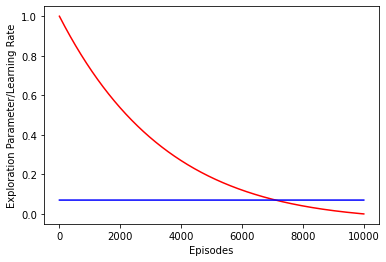

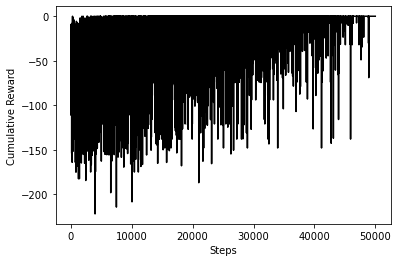

2025-05-18
It took 4.951889336109161 minutes to run 10000 episodes.


In [14]:
start_time = Time.time()

Q, agent_paths, ave_episode_reward = EdgeSwap_Q_learning(epsilon, 
                                                   episode_num, 
                                                   path_num, 
                                                   table_size, 
                                                   max_path_length, 
                                                   discount_factor, 
                                                   env, 
                                                   lr, 
                                                   save_plots, 
                                                   nodes_per_patch,
                                                   action_space_values,
                                                   action_space_size,
                                                   n_step_lookup)



#Save the Q table.
if save_data:
    time = Time.localtime()
    current_time = Time.strftime("%H-%M-%S", time)
    date = datetime.now()
    d = date.isoformat()[0:10]
    data_save = [Q]
    data_save = np.array(data_save, dtype=object)
    print(d[0:10])
    np.save('Models/'
            +'Q_EP_'
            +str(episode_num)+'_P_'+str(path_num)
            +'_PL_'+ str(max_path_length)+'_Date_'+d+'_.npy',data_save)
    

    
end_time = Time.time()

print(f'It took {(end_time-start_time)/60} minutes to run {episode_num} episodes.')



$\Large \textbf{Examine the optimal policy}$

[[0 0 0 1 1 1 0 0 1 1 0 0 1 0 0]]


####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################
####################################################################################################


--|||-- Current state cost:  285  add action coeffs:  [0, 2]
Compute directional reward: 0 for state: [0 0 1 1 0 1 0 1 0 0 0 1 0 1 0], [(0, 3), (0, 4), (1, 2), (1, 4), (2, 5), (3, 5)],  [0, 2] (0, 3) (1, 2)
--|||-- Current state cost:  226  add action coeffs:  [3, 5]
Compute directional reward: 0 for state: [0 0 1 1 0 1 1 0 0 0 0 1 0 0 1], [(0, 3), (0, 4), (1, 2), (1, 3), (2, 5), (4, 5)],  [3, 5] (1, 3) (4, 5)
--|||-- Current state cost:  204  add actio

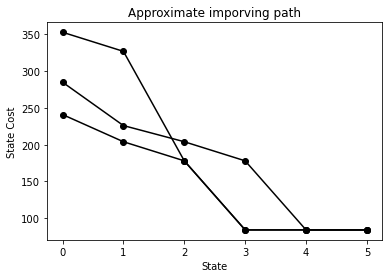

In [20]:
data_load = np.load('Models/'
                    +'Q_EP_'
                    +str(episode_num)
                    +'_P_'+str(path_num)
                    +'_PL_'
                    + str(max_path_length)
                    +'_Date_2025-05-18'
                    +'_.npy',allow_pickle=True)
Q = data_load[0] 

path_rewards = {}

with open('Models' + os.sep + 'visited_states.pkl', 'rb') as f:
    starting_states = pickle.load(f)
print(np.array([initial_states[0]]))
trajectory_num = 3

random_initial_states = starting_states[np.random.choice(starting_states.shape[0], trajectory_num, replace=False)]
random_initial_states = np.concatenate((np.array([initial_states[0]]), random_initial_states), axis=0)


for t in range(trajectory_num):
    print("\n")
    print("####################################################################################################")
    print("####################################################################################################")
    print("####################################################################################################")
    print("####################################################################################################")
    print("####################################################################################################")
    print("\n")
    #Initialize the environment.
    env = Env(random_initial_states[t,:], # initial_states[0]initial_state
             reward_list, # edge_weights
             episode_num, # total_episodes
             max_path_lengths[0],
             50, # show_path_num
             starting_states,  # visited_states
             available_actions, # basis_moves
             nodes_per_patch, # node_num
             0, # P
             best_states,
             best_states_size,
             objective_table,
             True,
             discount_factor,
             reward_function = reward_cost
             )

    path_reward \
    = edge_swap_policy_evaluation(Q,env,reward_list,max_path_lengths[0],action_space_values,action_space_size, nodes_per_patch)
    path_rewards[t] = path_reward



[285, 226, 204, 178, 84, 84]
[241, 204, 178, 84, 84, 84]
[353, 327, 178, 84, 84, 84]


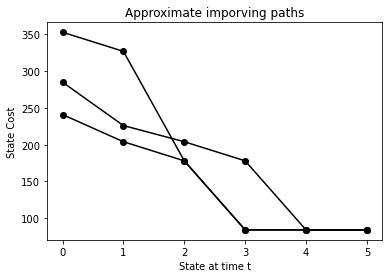

In [22]:
    
for t in range(trajectory_num):
    improving_state_rewards = [tup[0] for tup in path_rewards[t]]
    plt.plot(improving_state_rewards, '-o', color='black')
    plt.title("Approximate imporving paths")
    plt.xlabel("State at time t")
    plt.ylabel("State Cost")
    print(improving_state_rewards)
plt.savefig('Figures/ImprovingPath4.png')
plt.show()